In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.model_selection import ParameterGrid

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
import surprise

In [2]:
%matplotlib inline

# Import and clean data

In [3]:
df_clean = pd.read_csv('df_clean.csv',index_col=0 )

In [4]:
df_clean.drop(['timestamp_interaction', 'timestamp_article','sessionId'], inplace=True, axis=1)

In [5]:
# get the personal ID with more than 5 interactions.(interact with 5 unique articles)
users_interactions_count_df = df_clean.groupby(['personId', 'contentId']).size().groupby('personId').size()
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users with at least 5 interactions: 1139


In [7]:
# get the whole dataframe with users with more than 5 interactions.
interactions_from_selected_users_df = df_clean.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions from users with at least 5 interactions: 55046


In [8]:
interactions_from_selected_users_df.head(3)

,eventType,contentId,authorPersonId,title,text,lang,personId,userAgent,userRegion,userCountry,eventStrength,datetime_interaction,datetime_article
0,CONTENT REMOVED,-6451309518266745024,4340306774493623681,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,4340306774493623681,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5...,SP,BR,1.0,2016-03-28 15:19:39,2016-03-28 15:16:01
1,CONTENT REMOVED,-6451309518266745024,4340306774493623681,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,4340306774493623681,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5...,SP,BR,1.0,2016-03-28 15:19:39,2016-03-28 15:17:47
2,CONTENT SHARED,4119190424078847945,4340306774493623681,Blockchain Technology Could Put Bank Auditors ...,When most people think about computers and rob...,en,4340306774493623681,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5...,SP,BR,1.0,2016-03-28 15:49:59,2016-04-15 14:09:23


In [10]:
interactions_from_selected_users_df.shape

(55046, 13)

In [19]:
len(interactions_from_selected_users_df.contentId.unique())

2973

## Convert the differenct interaction type to socres

In Deskdrop, users are allowed to view an article many times, and interact with them in different ways (eg. like or comment). Thus, to model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [8]:
def smooth_user_preference(x):
    return math.log(x+1)

In [9]:
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum().apply(smooth_user_preference).reset_index()

In [10]:
interactions_full_df.shape

(38652, 3)

In [11]:
interactions_full_df.head(15)

,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,0.693147
1,-9223121837663643404,-8377626164558006982,0.693147
2,-9223121837663643404,-8208801367848627943,0.693147
3,-9223121837663643404,-8187220755213888616,0.693147
4,-9223121837663643404,-7423191370472335463,2.197225
5,-9223121837663643404,-7331393944609614247,0.693147
6,-9223121837663643404,-6872546942144599345,0.693147
7,-9223121837663643404,-6728844082024523434,0.693147
8,-9223121837663643404,-6590819806697898649,0.693147
9,-9223121837663643404,-6558712014192834002,0.693147


## partition the data into train and test set

In [87]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

## Evaluation

We chose to work with Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set. The Top-N accuracy metric choosen was Recall@N which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.

In [88]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [89]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [101]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100
class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(interactions_from_selected_users_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)
    
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)
        
        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    # catalog coverage
    def item_coverage(self, model):
        recs = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df))
                                                   
            for i in list(person_recs_df.contentId):  
                if  i not in recs:
                    recs.append(i)
        
        iC = len(recs)/len(interactions_full_df.contentId.unique())
        return iC


In [102]:
model_evaluator = ModelEvaluator() 

## Popularity model

recommends to a user the most popular items that the user has not previously consumed. 

In [17]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(5)

,contentId,eventStrength
0,-4029704725707465084,213.304815
1,-133139342397538859,137.688360
2,-6783772548752091658,129.163199
3,1469580151036142903,118.215537
4,-8208801367848627943,111.172144


In [18]:
item_popularity_df.sort_values('eventStrength', ascending = False) \
                               .head(5)

,contentId,eventStrength
0,-4029704725707465084,213.304815
1,-133139342397538859,137.688360
2,-6783772548752091658,129.163199
3,1469580151036142903,118.215537
4,-8208801367848627943,111.172144


In [19]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=5, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    


In [20]:
popularity_model = PopularityRecommender(item_popularity_df)

In [112]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_item_coverage = model_evaluator.item_coverage(popularity_model)
print('\nCatalog Coverage:\n%s' % pop_item_coverage)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1138 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.24472901306428663, 'recall@10': 0.36502392963394126}

Catalog Coverage:
0.004372687521022536


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
29,3609194402293569455,55,33,192,0.286458,0.171875
35,-2626634673110551643,18,7,134,0.134328,0.052239
63,-1032019229384696495,13,6,128,0.101562,0.046875
3,-1443636648652872475,16,9,117,0.136752,0.076923
51,-2979881261169775358,36,22,88,0.409091,0.250000
148,-3596626804281480007,12,8,80,0.150000,0.100000
48,692689608292948411,17,11,69,0.246377,0.159420
89,1116121227607581999,29,16,69,0.420290,0.231884
191,-9016528795238256703,20,14,69,0.289855,0.202899
72,3636910968448833585,22,15,68,0.323529,0.220588


## Matrix factorization

In [22]:
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_ids = list(users_items_pivot_matrix_df.index)

/Users/shirley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [24]:
NUMBER_OF_FACTORS_MF = 15
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [25]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
#Converting the reconstructed matrix back to a Pandas dataframe
mf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
mf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.041182,-0.001708,-0.020489,0.013298,-0.002006,-0.000347,0.006874,0.008973,-0.012535,0.015736,...,0.023179,-0.045982,-0.002959,-0.000279,-0.016758,-0.002326,0.003267,-0.011808,0.003548,0.011009
-9194572880052200111,0.002612,-0.000383,-0.012756,0.000063,0.005168,0.001122,0.008822,0.005399,-0.005331,0.003649,...,-0.002171,0.146461,0.000057,-0.004694,0.061447,0.010333,0.001406,-0.010640,-0.000631,0.017986
-9192549002213406534,0.014067,-0.001295,-0.026958,-0.005460,0.005498,0.007294,0.015584,0.023718,-0.009751,0.015802,...,0.011019,0.067646,0.006554,0.004124,0.002582,0.006467,0.008306,-0.024691,0.010180,-0.016251
-9190737901804729417,0.009503,-0.000104,-0.005551,0.003137,-0.000560,-0.000114,0.000636,-0.000220,-0.002878,0.006577,...,0.005732,-0.002794,-0.000336,-0.001259,-0.001901,-0.000640,0.001069,-0.003559,0.001390,0.000753
-9189659052158407108,0.015924,0.000171,0.016812,-0.003947,0.007174,0.000972,0.009029,0.003128,0.011831,0.007775,...,0.003671,0.129144,0.000142,0.000860,0.046882,0.006341,0.006607,0.016471,0.022454,0.067949
-9184137057748005562,-0.000333,-0.000119,0.002363,-0.000200,-0.000099,0.000411,-0.000083,0.000134,-0.000490,0.002495,...,0.001130,0.001461,-0.000254,-0.000264,-0.000332,0.000182,0.000519,0.002795,0.002691,-0.006930
-9176143510534135851,0.045042,0.001227,0.026286,0.009004,-0.002507,-0.003135,0.007177,0.015412,0.008947,0.014315,...,0.014308,0.079764,-0.005022,-0.003074,-0.011336,-0.003247,0.003635,0.027547,0.035765,0.077041
-9172673334835262304,-0.002438,-0.000184,-0.002548,-0.000634,-0.000694,0.000819,0.000286,0.000921,-0.002003,0.001931,...,0.001673,-0.004065,0.000792,0.000049,0.000280,-0.000541,0.001464,-0.001985,0.001187,-0.022070
-9171475473795142532,0.005900,0.000015,0.000931,0.003514,0.000201,-0.000009,0.001634,0.000768,-0.000904,0.002144,...,0.001828,0.005552,0.000544,0.001468,0.010293,0.001011,0.001110,0.002073,0.000054,-0.001059


In [26]:
class MFRecommender:
    
    MODEL_NAME = 'Matrix Factorization'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

In [27]:
mf_recommender_model = MFRecommender(mf_preds_df)

In [113]:
print('Evaluating SVD Matrix Factorization model...')
svd_global_metrics, svd_detailed_results_df = model_evaluator.evaluate_model(mf_recommender_model)
print('\nGlobal metrics:\n%s' % svd_global_metrics)
svd_item_coverage = model_evaluator.item_coverage(mf_recommender_model)
print('\nCatalog Coverage:\n%s' % svd_item_coverage)
svd_detailed_results_df.head(10)

Evaluating SVD Matrix Factorization model...
1138 users processed

Global metrics:
{'modelName': 'Matrix Factorization', 'recall@5': 0.32673651532790066, 'recall@10': 0.45479239425688783}

Catalog Coverage:
0.1231079717457114


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
29,3609194402293569455,59,38,192,0.307292,0.197917
35,-2626634673110551643,42,17,134,0.313433,0.126866
63,-1032019229384696495,36,18,128,0.281250,0.140625
3,-1443636648652872475,36,25,117,0.307692,0.213675
51,-2979881261169775358,41,30,88,0.465909,0.340909
148,-3596626804281480007,30,21,80,0.375000,0.262500
48,692689608292948411,21,12,69,0.304348,0.173913
89,1116121227607581999,35,25,69,0.507246,0.362319
191,-9016528795238256703,30,21,69,0.434783,0.304348
72,3636910968448833585,19,13,68,0.279412,0.191176


## Collaborative model

item-item collaborative filtering model

In [276]:
utility = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

utility.head(10)

contentId,-9222795471790223670,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
# generate the degree matrix q which is the sum of squar of column in utility matrix
Q = np.zeros((utility.shape[1],utility.shape[1]))
for i in range(utility.shape[1]):
    Q[i][i] = 1/sum(utility.iloc[:,i]**2)

In [278]:
utility_matrix = utility.values
users_ids = list(utility.index)

In [279]:
S = np.sqrt(Q).dot(utility_matrix.T).dot(utility_matrix).dot(np.sqrt(Q))

In [293]:
item_item = utility_matrix.dot(S)

In [294]:
item_preds_df = pd.DataFrame(item_item, columns = utility.columns, index=users_ids).transpose()
item_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,2.430488,0.000000,0.000000,0.885413,0.000000,0.156103,0.924746,0.930553,0.532152,0.941949,...,0.848798,1.743665,0.025003,0.399255,0.702988,0.000000,0.102263,0.253371,0.365540,0.841113
-9194572880052200111,0.568131,0.023715,0.030814,0.014274,0.394455,0.067928,0.306897,0.367122,0.387021,0.447800,...,0.044216,2.389307,0.076201,0.181209,1.326839,0.380906,0.322528,0.106399,0.412994,1.937088
-9192549002213406534,2.671395,0.139553,0.158358,0.284096,0.331326,0.687090,1.563968,1.467385,1.379991,1.922997,...,0.865380,6.129047,0.546827,0.669538,2.585345,0.308180,0.654899,0.456308,0.995909,5.053353
-9190737901804729417,0.850423,0.000000,0.000000,0.205512,0.000000,0.000000,0.092788,0.000000,0.000000,0.128769,...,0.354754,0.715905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035806,0.276108
-9189659052158407108,1.897249,0.189997,0.319191,0.225910,0.490745,0.245412,1.070546,0.411921,1.051700,1.195062,...,0.655400,4.731636,0.171808,0.461842,2.538930,0.326517,0.563522,0.535773,0.906319,4.399846
-9184137057748005562,0.182441,0.000000,0.000000,0.000000,0.000000,0.000000,0.192244,0.124396,0.145451,1.807898,...,0.227567,0.197297,0.000000,0.000000,0.000000,0.000000,0.345252,0.000000,0.416408,0.091769
-9176143510534135851,2.041955,0.140635,0.265479,1.102427,0.098772,0.097348,0.947025,1.390212,0.895314,2.251826,...,0.811177,3.204166,0.018919,0.421346,1.314822,0.080482,0.533291,0.466634,0.996635,2.330321
-9172673334835262304,0.735865,0.000000,0.000000,0.000000,0.132381,0.255479,0.292911,0.124396,0.270079,1.125008,...,0.227567,2.140137,0.245509,0.084899,0.623819,0.000000,0.221406,0.084899,0.652173,0.678006
-9171475473795142532,1.251041,0.000000,0.000000,0.112321,0.098777,0.000000,0.388669,0.000000,0.000000,0.680280,...,0.266898,1.135221,0.000000,0.063348,0.429333,0.000000,0.000000,0.270349,0.000000,0.278874


In [295]:
class ItemRecommender:
    
    MODEL_NAME = 'Collaborative Filtering '
    
    def __init__(self, item_predictions_df, items_df=None):
        self.item_predictions_df = item_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.item_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

In [296]:
item_recommender_model = ItemRecommender(item_preds_df)

In [297]:
print('Evaluating Collaborative Filtering (item-item) model...')
item_global_metrics, item_detailed_results_df = model_evaluator.evaluate_model(item_recommender_model)
print('\nGlobal metrics:\n%s' % item_global_metrics)
item_item_coverage = model_evaluator.item_coverage(item_recommender_model)
print('\nCatalog Coverage:\n%s' % item_item_coverage)
item_detailed_results_df.head(10)

Evaluating Collaborative Filtering (item-item) model...
1138 users processed

Global metrics:
{'modelName': 'Collaborative Filtering ', 'recall@5': 0.26839994826025093, 'recall@10': 0.393092743500194}

Catalog Coverage:
0.5506222670702994


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
29,3609194402293569455,37,17,192,0.192708,0.088542
35,-2626634673110551643,28,19,134,0.208955,0.141791
63,-1032019229384696495,49,31,128,0.382812,0.242188
3,-1443636648652872475,40,24,117,0.341880,0.205128
51,-2979881261169775358,25,15,88,0.284091,0.170455
148,-3596626804281480007,29,18,80,0.362500,0.225000
48,692689608292948411,15,7,69,0.217391,0.101449
89,1116121227607581999,21,11,69,0.304348,0.159420
191,-9016528795238256703,21,15,69,0.304348,0.217391
72,3636910968448833585,18,9,68,0.264706,0.132353


## User-user based recommender

In [39]:
P = np.zeros((utility.shape[0],utility.shape[0]))
for i in range(utility.shape[0]):
    if sum(utility.iloc[i,:])!=0:
        P[i][i] = 1/sum(utility.iloc[i,:]**2)
    else: P[i][i] = 0

In [298]:
user_user = np.sqrt(P).dot(utility_matrix).dot(utility_matrix.T).dot(np.sqrt(P)).dot(utility_matrix)

In [299]:
user_preds_df = pd.DataFrame(user_user, columns = utility.columns, index=users_ids).transpose()
user_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.354986,0.000000,0.000000,0.249470,0.000000,0.023879,0.148642,0.096912,0.083995,0.118644,...,0.259578,0.160886,0.017829,0.093558,0.067237,0.000000,0.026675,0.100033,0.082440,0.063408
-9194572880052200111,0.320328,0.014573,0.201097,0.031751,0.717018,0.049690,0.123616,0.265825,0.239837,0.142322,...,0.016827,0.539566,0.030027,0.113038,0.487250,0.723742,0.125439,0.197119,0.463240,0.797144
-9192549002213406534,0.939465,0.094134,0.584787,0.103947,0.290629,0.610392,0.509305,0.464758,0.583265,0.541935,...,0.446609,1.451265,0.291921,0.305188,0.923594,0.236596,0.457940,0.657406,0.755758,1.554455
-9190737901804729417,0.163550,0.000000,0.000000,0.075742,0.000000,0.000000,0.028995,0.000000,0.000000,0.027056,...,0.180127,0.074593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016770,0.022549
-9189659052158407108,0.652079,0.343753,0.760906,0.096814,0.476254,0.153943,0.274536,0.275332,0.448919,0.315980,...,0.319372,0.981063,0.064391,0.302685,0.769924,0.351802,0.362263,0.486793,0.692376,0.888147
-9184137057748005562,0.013049,0.000000,0.000000,0.000000,0.000000,0.000000,0.010830,0.010648,0.015946,0.086905,...,0.034724,0.013063,0.000000,0.000000,0.000000,0.000000,0.040841,0.000000,0.052008,0.006674
-9176143510534135851,0.448222,0.064256,0.676019,0.465821,0.050720,0.029540,0.235007,0.218369,0.275296,0.474390,...,0.247771,0.682434,0.069317,0.250699,0.300159,0.043367,0.197432,0.556527,0.622942,0.378086
-9172673334835262304,0.036495,0.000000,0.000000,0.000000,0.011870,0.028925,0.016897,0.008307,0.024880,0.044596,...,0.027089,0.056056,0.018705,0.012100,0.032777,0.000000,0.022974,0.009144,0.052273,0.020269
-9171475473795142532,0.182067,0.000000,0.000000,0.034932,0.018788,0.000000,0.053490,0.000000,0.000000,0.092606,...,0.060186,0.064902,0.000000,0.019152,0.048819,0.000000,0.000000,0.085489,0.000000,0.038595


In [300]:
user_recommender_model = ItemRecommender(user_preds_df)

In [301]:
print('Evaluating Collaborative Filtering (user-user) model...')
user_global_metrics, user_detailed_results_df = model_evaluator.evaluate_model(user_recommender_model)
print('\nGlobal metrics:\n%s' % user_global_metrics)
user_item_coverage = model_evaluator.item_coverage(user_recommender_model)
print('\nCatalog Coverage:\n%s' % user_item_coverage)
user_detailed_results_df.head(10)

Evaluating Collaborative Filtering (user-user) model...
1138 users processed

Global metrics:
{'modelName': 'Collaborative Filtering ', 'recall@5': 0.34859655930668737, 'recall@10': 0.48570689432156255}

Catalog Coverage:
0.11604439959636731


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
29,3609194402293569455,59,36,192,0.307292,0.187500
35,-2626634673110551643,28,18,134,0.208955,0.134328
63,-1032019229384696495,43,17,128,0.335938,0.132812
3,-1443636648652872475,29,22,117,0.247863,0.188034
51,-2979881261169775358,49,33,88,0.556818,0.375000
148,-3596626804281480007,24,14,80,0.300000,0.175000
48,692689608292948411,18,12,69,0.260870,0.173913
89,1116121227607581999,36,24,69,0.521739,0.347826
191,-9016528795238256703,24,17,69,0.347826,0.246377
72,3636910968448833585,23,16,68,0.338235,0.235294


## content based model

In [219]:
articles_df = df_clean.drop_duplicates('text')

#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<2941x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 617844 stored elements in Compressed Sparse Row format>

To model the user profile, we take all the item profiles the user has interacted and average them. The average is weighted by the interaction strength, in other words, the articles the user has interacted the most (eg. liked or commented) will have a higher strength in the final user profile.

In [214]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [215]:
user_profiles = build_users_profiles()

In [216]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

In [217]:
content_based_recommender_model = ContentBasedRecommender()

In [218]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_item_coverage = model_evaluator.item_coverage(content_based_recommender_model)
print('\nCatalog Coverage:\n%s' % cb_item_coverage)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1138 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.4227137498383133, 'recall@10': 0.5317552709869358}

Catalog Coverage:
0.4870501177262025


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
29,3609194402293569455,36,19,192,0.187500,0.098958
35,-2626634673110551643,29,17,134,0.216418,0.126866
63,-1032019229384696495,34,15,128,0.265625,0.117188
3,-1443636648652872475,49,27,117,0.418803,0.230769
51,-2979881261169775358,20,13,88,0.227273,0.147727
148,-3596626804281480007,26,17,80,0.325000,0.212500
48,692689608292948411,21,13,69,0.304348,0.188406
89,1116121227607581999,16,8,69,0.231884,0.115942
191,-9016528795238256703,15,7,69,0.217391,0.101449
72,3636910968448833585,11,6,68,0.161765,0.088235


## summary of the model we have 

In [72]:
result = pd.DataFrame({'model':['popularity model', 'matrix factorization', 'collaborative filtering(item)', 'collaborative filtering(user)', 'content-based'],\
                       'top5recall':[pop_global_metrics['recall@5'], svd_global_metrics['recall@5'], item_global_metrics['recall@5'], user_global_metrics['recall@5'], \
                                    cb_global_metrics['recall@5']],\
                      'top10recall':[pop_global_metrics['recall@10'], svd_global_metrics['recall@10'], item_global_metrics['recall@10'],user_global_metrics['recall@10'], \
                                    cb_global_metrics['recall@10']]})

In [352]:
result_2 = pd.DataFrame({'model':['popularity model', 'matrix factorization', 'collaborative filtering(item)', 'collaborative filtering(user)', 'content-based'],\
                       'top5recall':[pop_global_metrics['recall@5'], svd_global_metrics['recall@5'], item_global_metrics['recall@5'], user_global_metrics['recall@5'], \
                                    cb_global_metrics['recall@5']],\
                      'top10recall':[pop_global_metrics['recall@10'], svd_global_metrics['recall@10'], item_global_metrics['recall@10'],user_global_metrics['recall@10'], \
                                    cb_global_metrics['recall@10']],\
                        'item coverage':[pop_item_coverage, svd_item_coverage, item_item_coverage, user_item_coverage, cb_item_coverage]})

In [353]:
catalog = pd.DataFrame({'model':['popularity model', 'matrix factorization', 'collaborative filtering(item)', 'collaborative filtering(user)', 'content-based'],'item coverage':[pop_item_coverage, svd_item_coverage, item_item_coverage, user_item_coverage, cb_item_coverage]})

In [75]:
results = pd.melt(
pd.DataFrame(result),
id_vars=['model'],
value_vars=[
'top5recall','top10recall'
],
value_name='scores'
)
results = results.rename(columns = {'variable' : 'metrics'})

In [361]:
results_2 = pd.melt(
pd.DataFrame(result_2),
id_vars=['model','item coverage'],
value_vars=[
'top5recall','top10recall'
],
value_name='scores'
)
results_2 = results_2.rename(columns = {'variable' : 'metrics'})

In [362]:
results_2

,model,item coverage,metrics,scores
0,popularity model,0.004373,top5recall,0.244729
1,matrix factorization,0.123108,top5recall,0.284439
2,collaborative filtering(item),0.550622,top5recall,0.268400
3,collaborative filtering(user),0.116044,top5recall,0.348597
4,content-based,0.487050,top5recall,0.451300
5,popularity model,0.004373,top10recall,0.365024
6,matrix factorization,0.123108,top10recall,0.388824
7,collaborative filtering(item),0.550622,top10recall,0.393093
8,collaborative filtering(user),0.116044,top10recall,0.485707
9,content-based,0.487050,top10recall,0.558013


In [366]:
def plot_results(results, title,xlable,ylable, huelable):
    f, ax = plt.subplots(figsize=(8, 5))
    sns.pointplot(ax=ax,
    x= xlable,
    y= ylable,
    hue = huelable,
    data=results)
    ax.set_xlabel(xlable)
    ax.set_ylabel('scores')
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.legend(loc='lower right')

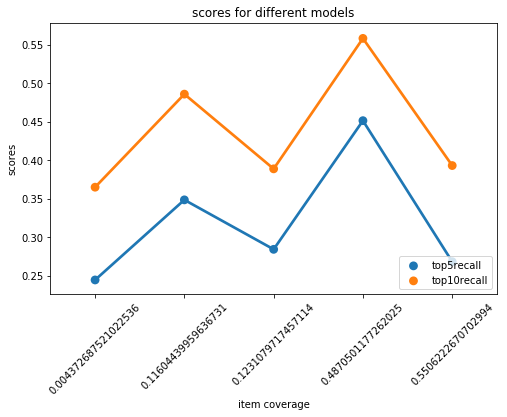

In [367]:
plot_results(results_2,'scores for different models','item coverage','scores','metrics')

[Text(0, 0, 'popularity model'),
 Text(0, 0, 'matrix factorization'),
 Text(0, 0, 'collaborative filtering(item)'),
 Text(0, 0, 'collaborative filtering(user)'),
 Text(0, 0, 'content-based')]

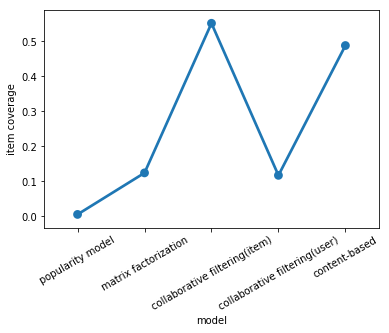

In [354]:
g = sns.pointplot(
    x= 'model',
    y= 'item coverage',
    data = catalog)
g.set_xticklabels(g.get_xticklabels(),rotation=30)

## Tune parameters

### tune vectorizer for content based model

In [220]:
para = {'ngram_range':[(1,1),(1,2),(1,3),(1,4),(1,5)], 'max_features' : [500,1000,2000,5000,10000]}
grid_search = ParameterGrid(para)
articles_df = df_clean.drop_duplicates('text')

In [221]:
scores_cb = {}
for i in grid_search:
    vectorizer = TfidfVectorizer(analyzer='word',max_features = i['max_features'],ngram_range = i['ngram_range'],
                     stop_words=stopwords_list)
    item_ids = articles_df['contentId'].tolist()
    tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
    tfidf_feature_names = vectorizer.get_feature_names()
    user_profiles = build_users_profiles()
    content_based_recommender_model = ContentBasedRecommender()
    cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
    scores_cb[str(i['max_features'])+' '+str(i['ngram_range'])] = cb_global_metrics

1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed


In [227]:
score_cb = pd.DataFrame(scores_cb).T
del score_cb['modelName']
score_cb['parameters'] = score_cb.index

In [232]:
results = pd.melt(
score_cb,
id_vars=['parameters'],
value_vars=[
'recall@10', 'recall@5'
],
value_name='scores'
)
results = results.rename(columns = {'variable' : 'metrics'})

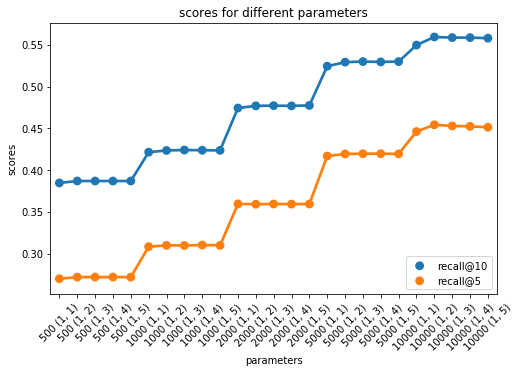

In [249]:
plot_results(results,'scores for different parameters','parameters','scores','metrics')

The best combination is ngram range = (1,2) and maximum features  = 10000

### tune number of latent factors

In [145]:
k = [5,10,15,20,25,30,50,100]
scores = {}
for i in k:
    U, sigma, Vt = svds(users_items_pivot_matrix, k = i)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
#Converting the reconstructed matrix back to a Pandas dataframe
    mf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
    mf_recommender_model = MFRecommender(mf_preds_df, interactions_from_selected_users_df)
    svd_global_metrics, svd_detailed_results_df = model_evaluator.evaluate_model(mf_recommender_model)
    scores[i] = svd_global_metrics

1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed
1138 users processed


In [152]:
score = pd.DataFrame(scores).T
del score['modelName']
score['number of latent factors'] = score.index

In [173]:
results = pd.melt(
score,
id_vars=['number of latent factors'],
value_vars=[
'recall@10', 'recall@5'
],
value_name='scores'
)
results = results.rename(columns = {'variable' : 'metrics'})

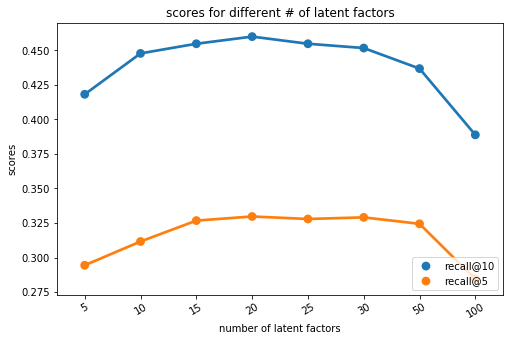

In [174]:
plot_results(results,'scores for different # of latent factors','number of latent factors','scores','metrics')

In [175]:
scores[20]

{'modelName': 'Matrix Factorization',
 'recall@5': 0.32971155089897813,
 'recall@10': 0.45996636916310957}

Our best parameteres for matrix factorization is k =20 and the top 5 recall is 0.330, top 10 recall is 0.460